# Conditional Generative Adversarial Networks (CGAN) on MNIST
This notebook implements and trains a Conditional Generative Adversarial Network (CGAN) on the MNIST dataset using Keras.

## Introduction
A Conditional Generative Adversarial Network (CGAN) is a type of GAN where both the generator and the discriminator are conditioned on additional information. In this case, the generator receives both a random noise vector and a one-hot encoded label as input, allowing it to generate specific images conditioned on the label. The discriminator is also conditioned on the label to determine whether an image is real or fake for a given class.

### References:
- [1] Radford, Alec, Luke Metz, and Soumith Chintala. *"Unsupervised representation learning with deep convolutional generative adversarial networks."* arXiv preprint arXiv:1511.06434 (2015).
- [2] Mirza, Mehdi, and Simon Osindero. *"Conditional generative adversarial nets."* arXiv preprint arXiv:1411.1784 (2014).


## Imports tf.keras

In [25]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from tensorflow.keras.layers import Activation, Dense, Input
from tensorflow.keras.layers import Conv2D, Flatten
from tensorflow.keras.layers import Reshape, Conv2DTranspose
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import concatenate
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.models import load_model

import numpy as np
import math
import matplotlib.pyplot as plt
import os
import argparse


## Model Architecture


### Generator


The generator takes two inputs:
- A noise vector `z` (latent space vector).
- A one-hot encoded label that specifies the class of the generated image.

The noise vector and the label are concatenated, and the generator produces an image conditioned on the label.


In [5]:
def build_generator(inputs, labels, image_size):
    """Build a Generator Model

    Inputs are concatenated before Dense layer.
    Stack of BN-ReLU-Conv2DTranpose to generate fake images.
    Output activation is sigmoid instead of tanh in orig DCGAN.
    Sigmoid converges easily.

    Arguments:
        inputs (Layer): Input layer of the generator (the z-vector)
        labels (Layer): Input layer for one-hot vector to condition
            the inputs
        image_size: Target size of one side (assuming square image)

    Returns:
        generator (Model): Generator Model
    """
    image_resize = image_size // 4
    # network parameters
    kernel_size = 5
    layer_filters = [128, 64, 32, 1]

    x = concatenate([inputs, labels], axis=1)
    x = Dense(image_resize * image_resize * layer_filters[0])(x)
    x = Reshape((image_resize, image_resize, layer_filters[0]))(x)

    for filters in layer_filters:
        # first two convolution layers use strides = 2
        # the last two use strides = 1
        if filters > layer_filters[-2]:
            strides = 2
        else:
            strides = 1
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = Conv2DTranspose(filters=filters,
                            kernel_size=kernel_size,
                            strides=strides,
                            padding='same')(x)

    x = Activation('sigmoid')(x)
    # input is conditioned by labels
    generator = Model([inputs, labels], x, name='generator')
    return generator

### Discriminator

The discriminator takes two inputs:
- An image (either real or fake).
- A one-hot encoded label.

The discriminator evaluates whether the image is real or fake, conditioned on the label.

Both models use convolutional layers to handle image data. The generator uses transposed convolutions to upsample the noise vector into an image, while the discriminator uses regular convolutions to classify the input image.

In [6]:
def build_discriminator(inputs, labels, image_size):
    """Build a Discriminator Model

    Inputs are concatenated after Dense layer.
    Stack of LeakyReLU-Conv2D to discriminate real from fake.
    The network does not converge with BN so it is not used here
    unlike in DCGAN paper.

    Arguments:
        inputs (Layer): Input layer of the discriminator (the image)
        labels (Layer): Input layer for one-hot vector to condition
            the inputs
        image_size: Target size of one side (assuming square image)

    Returns:
        discriminator (Model): Discriminator Model
    """
    kernel_size = 5
    layer_filters = [32, 64, 128, 256]

    x = inputs

    y = Dense(image_size * image_size)(labels)
    y = Reshape((image_size, image_size, 1))(y)
    x = concatenate([x, y])

    for filters in layer_filters:
        # first 3 convolution layers use strides = 2
        # last one uses strides = 1
        if filters == layer_filters[-1]:
            strides = 1
        else:
            strides = 2
        x = LeakyReLU(alpha=0.2)(x)
        x = Conv2D(filters=filters,
                   kernel_size=kernel_size,
                   strides=strides,
                   padding='same')(x)

    x = Flatten()(x)
    x = Dense(1)(x)
    x = Activation('sigmoid')(x)
    # input is conditioned by labels
    discriminator = Model([inputs, labels], x, name='discriminator')
    return discriminator

## Training Process
The CGAN training alternates between updating the discriminator and the adversarial model (generator + discriminator).

1. **Discriminator training**: 
   - Real images are paired with their corresponding labels.
   - Fake images are generated by the generator, conditioned on random labels.
   - The discriminator is trained to distinguish real images from fake images for each label.

2. **Generator (Adversarial) training**:
   - The generator aims to produce images that are classified as real by the discriminator.
   - The discriminator weights are frozen during adversarial training, allowing only the generator to update.

This process continues for several iterations until the generator can produce realistic images conditioned on the input labels.

![](architecture.jpg)

In [7]:
def plot_images(generator,
                noise_input,
                noise_class,
                show=False,
                step=0,
                model_name="gan"):
    """Generate fake images and plot them

    For visualization purposes, generate fake images
    then plot them in a square grid

    Arguments:
        generator (Model): The Generator Model for fake images generation
        noise_input (ndarray): Array of z-vectors
        show (bool): Whether to show plot or not
        step (int): Appended to filename of the save images
        model_name (string): Model name

    """
    os.makedirs(model_name, exist_ok=True)
    filename = os.path.join(model_name, "%05d.png" % step)
    images = generator.predict([noise_input, noise_class])
    print(model_name , " labels for generated images: ", np.argmax(noise_class, axis=1))
    plt.figure(figsize=(2.2, 2.2))
    num_images = images.shape[0]
    image_size = images.shape[1]
    rows = int(math.sqrt(noise_input.shape[0]))
    for i in range(num_images):
        plt.subplot(rows, rows, i + 1)
        image = np.reshape(images[i], [image_size, image_size])
        plt.imshow(image, cmap='gray')
        plt.axis('off')
    plt.savefig(filename)
    if show:
        plt.show()
    else:
        plt.close('all')

In [8]:
def train(models, data, params):
    """Train the Discriminator and Adversarial Networks

    Alternately train Discriminator and Adversarial networks by batch.
    Discriminator is trained first with properly labelled real and fake images.
    Adversarial is trained next with fake images pretending to be real.
    Discriminator inputs are conditioned by train labels for real images,
    and random labels for fake images.
    Adversarial inputs are conditioned by random labels.
    Generate sample images per save_interval.

    Arguments:
        models (list): Generator, Discriminator, Adversarial models
        data (list): x_train, y_train data
        params (list): Network parameters

    """
    # the GAN models
    generator, discriminator, adversarial = models
    # images and labels
    x_train, y_train = data
    # network parameters
    batch_size, latent_size, train_steps, num_labels, model_name = params
    # the generator image is saved every 500 steps
    save_interval = 500
    # noise vector to see how the generator output evolves during training
    noise_input = np.random.uniform(-1.0, 1.0, size=[16, latent_size])
    # one-hot label the noise will be conditioned to
    noise_class = np.eye(num_labels)[np.arange(0, 16) % num_labels]
    # number of elements in train dataset
    train_size = x_train.shape[0]

    print(model_name,
          "Labels for generated images: ",
          np.argmax(noise_class, axis=1))

    for i in range(train_steps):
        # train the discriminator for 1 batch
        # 1 batch of real (label=1.0) and fake images (label=0.0)
        # randomly pick real images from dataset
        rand_indexes = np.random.randint(0, train_size, size=batch_size)
        real_images = x_train[rand_indexes]
        # corresponding one-hot labels of real images
        real_labels = y_train[rand_indexes]
        # generate fake images from noise using generator
        # generate noise using uniform distribution
        noise = np.random.uniform(-1.0,
                                  1.0,
                                  size=[batch_size, latent_size])
        # assign random one-hot labels
        fake_labels = np.eye(num_labels)[np.random.choice(num_labels,
                                                          batch_size)]

        # generate fake images conditioned on fake labels
        fake_images = generator.predict([noise, fake_labels])
        # real + fake images = 1 batch of train data
        x = np.concatenate((real_images, fake_images))
        # real + fake one-hot labels = 1 batch of train one-hot labels
        labels = np.concatenate((real_labels, fake_labels))

        # label real and fake images
        # real images label is 1.0
        y = np.ones([2 * batch_size, 1])
        # fake images label is 0.0
        y[batch_size:, :] = 0.0
        # train discriminator network, log the loss and accuracy
        loss, acc = discriminator.train_on_batch([x, labels], y)
        log = "%d: [discriminator loss: %f, acc: %f]" % (i, loss, acc)

        # train the adversarial network for 1 batch
        # 1 batch of fake images conditioned on fake 1-hot labels 
        # w/ label=1.0
        # since the discriminator weights are frozen in 
        # adversarial network only the generator is trained
        # generate noise using uniform distribution        
        noise = np.random.uniform(-1.0,
                                  1.0,
                                  size=[batch_size, latent_size])
        # assign random one-hot labels
        fake_labels = np.eye(num_labels)[np.random.choice(num_labels,
                                                          batch_size)]
        # label fake images as real or 1.0
        y = np.ones([batch_size, 1])
        # train the adversarial network 
        # note that unlike in discriminator training, 
        # we do not save the fake images in a variable
        # the fake images go to the discriminator input
        # of the adversarial for classification
        # log the loss and accuracy
        loss, acc = adversarial.train_on_batch([noise, fake_labels], y)
        log = "%s [adversarial loss: %f, acc: %f]" % (log, loss, acc)
        print(log)
        if (i + 1) % save_interval == 0:
            # plot generator images on a periodic basis
            plot_images(generator,
                        noise_input=noise_input,
                        noise_class=noise_class,
                        show=False,
                        step=(i + 1),
                        model_name=model_name)
    
    # save the model after training the generator
    # the trained generator can be reloaded for 
    # future MNIST digit generation
    generator.save(model_name + ".h5")

In [35]:
def build_and_train_models(trainCGAN = True):
    """
    Build and train the CGAN models using the MNIST dataset.
    This function performs the following steps:
    1. Loads and preprocesses the MNIST dataset.
    2. Defines network parameters such as latent size, batch size, training steps, learning rate, and decay.
    3. Builds the discriminator model.
    4. Builds the generator model.
    5. Constructs the adversarial model by combining the generator and discriminator.
    6. Compiles the models with appropriate optimizers and loss functions.
    7. Trains the discriminator and adversarial networks.
    Additionally, saves the architecture of each model as an image.
    
    Parameters:
    None
    
    Returns:
    None
    """
    # load MNIST dataset
    (x_train, y_train), (_, _) = mnist.load_data()

    # reshape data for CNN as (28, 28, 1) and normalize
    image_size = x_train.shape[1]
    x_train = np.reshape(x_train, [-1, image_size, image_size, 1])
    x_train = x_train.astype('float32') / 255

    num_labels = np.amax(y_train) + 1
    y_train = to_categorical(y_train)

    model_name = "cgan_mnist"
    # network parameters
    latent_size = 100
    batch_size = 64
    train_steps = 40000
    lr = 2e-4
    decay = 6e-8
    input_shape = (image_size, image_size, 1)
    label_shape = (num_labels, )

    # build discriminator model
    inputs = Input(shape=input_shape, name='discriminator_input')
    labels = Input(shape=label_shape, name='class_labels')

    discriminator = build_discriminator(inputs, labels, image_size)
    optimizer = RMSprop(learning_rate=lr, weight_decay=decay)
    discriminator.compile(loss='binary_crossentropy',
                          optimizer=optimizer,
                          metrics=['accuracy'])
    discriminator.summary()
    
    # Save discriminator architecture as an image
    plot_model(discriminator, to_file='architecture/discriminator_architecture.png', show_shapes=True)

    # build generator model
    input_shape = (latent_size, )
    inputs = Input(shape=input_shape, name='z_input')
    generator = build_generator(inputs, labels, image_size)
    generator.summary()
    
    # Save generator architecture as an image
    plot_model(generator, to_file='architecture/generator_architecture.png', show_shapes=True)

    # build adversarial model = generator + discriminator
    optimizer = RMSprop(learning_rate=lr*0.5, weight_decay=decay*0.5)
    discriminator.trainable = False
    outputs = discriminator([generator([inputs, labels]), labels])
    adversarial = Model([inputs, labels],
                        outputs,
                        name=model_name)
    adversarial.compile(loss='binary_crossentropy',
                        optimizer=optimizer,
                        metrics=['accuracy'])
    adversarial.summary()
    
    # Save adversarial architecture as an image
    plot_model(adversarial, to_file='architecture/adversarial_architecture.png', show_shapes=True)

    # train discriminator and adversarial networks
    models = (generator, discriminator, adversarial)
    data = (x_train, y_train)
    params = (batch_size, latent_size, train_steps, num_labels, model_name)
    if trainCGAN: train(models, data, params)

## Code Breakdown
The code is structured into several key components:

1. **`build_generator`**: 
   - This function defines the architecture of the generator model.
   - The input is a latent space vector concatenated with a one-hot label, and the output is a generated image.

2. **`build_discriminator`**:
   - This function defines the architecture of the discriminator.
   - The input is an image concatenated with a one-hot label, and the output is a classification score (real/fake).

3. **`train`**:
   - This function implements the training loop for both the generator and discriminator. It alternates between updating the discriminator and adversarial model.

4. **`plot_images`**:
   - This utility function generates and plots fake images produced by the generator during training, helping visualize the model's progress.

## Generate images

In [10]:
def test_generator(generator, class_label=None):
    noise_input = np.random.uniform(-1.0, 1.0, size=[16, 100])
    step = 0
    if class_label is None:
        num_labels = 10
        noise_class = np.eye(num_labels)[np.random.choice(num_labels, 16)]
    else:
        noise_class = np.zeros((16, 10))
        noise_class[:,class_label] = 1
        step = class_label

    plot_images(generator,
                noise_input=noise_input,
                noise_class=noise_class,
                show=True,
                step=step,
                model_name="test_outputs")


In [36]:
build_and_train_models(trainCGAN = False)

Model: "discriminator"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 class_labels (InputLayer)   [(None, 10)]                 0         []                            
                                                                                                  
 dense_14 (Dense)            (None, 784)                  8624      ['class_labels[0][0]']        
                                                                                                  
 discriminator_input (Input  [(None, 28, 28, 1)]          0         []                            
 Layer)                                                                                           
                                                                                                  
 reshape_9 (Reshape)         (None, 28, 28, 1)            0         ['dense_14[0][0]']

1/1 [==============================] - 0s 419ms/step
test_outputs  labels for generated images:  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


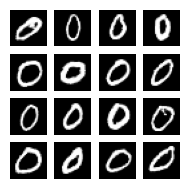

In [34]:
gen = load_model('cgan_mnist.h5')
test_generator(gen, 0)
#test_generator(gen, 1)
#test_generator(gen, 2)
#test_generator(gen, 3)
#test_generator(gen, 4)
#test_generator(gen, 5)
#test_generator(gen, 6)
#test_generator(gen, 7)
#test_generator(gen, 8)
#test_generator(gen, 9)

In [ ]:
#if you want to train the model, uncomment the following line
#build_and_train_models()
#that will take a long time to run, so be prepared, and make sure you have a GPU available
#you can also run the code in a cloud environment like Google Colab
#https://colab.research.google.com

## Conclusion
In this notebook, we implemented and trained a CGAN on the MNIST dataset. By conditioning the generator and discriminator on labels, we are able to generate specific digits based on the input label.

`python cgan-mnist.py --generator=cgan_mnist.h5 --digit=6`
